# Case Study - Predicting readmission for patients with Diabetes

In this project I will build a model predicting readmission for patients with diabetes.
The steps I will go through are:

* data exploration and data cleaning
* building training/validation/test samples
* model selection
* model evaluation

# Problem Definition

A hospital readmission is when a patient who is discharged from the hospital gets re-admitted again within a certain period of time. Readmission of patients is a huge financial burden on the insurance companies and other payment agencies. The hospitals also suffer because it reflects poorly on the quality of the service they provide.

In 2011, American hospitals spent over $41 billion on diabetic patients who got readmitted within 30 days of discharge. Determining factors that lead to higher readmission, and correspondingly being able to predict which patients will get readmitted can help hospitals save millions of dollars while improving quality of care.

# Dataset Exploration

The data used in this project is available at the UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008). 
The data consists of over 100000 hospital admissions from patients with diabetes from 130 US hospitals between 1999-2008.

## Load libraries required for data analysis

In [409]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import StrMethodFormatter
from matplotlib.legend_handler import HandlerLine2D
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%matplotlib inline

## Data

There are two csv files providing the necessary information. The first one is the data itself and the second file provides some supplemental information about certain variables in the dataset. 

In [410]:
dia = pd.read_csv('diabetic_data.csv')  # read data using read_csv function
dia1 = dia.copy()  # Make a copy of the original dataframe
ids_mapping = pd.read_csv('IDs_mapping.csv')  # read supplementary information

## Missing Data
**Below is a piece of code that summarizes the missingnees in the data**

In [411]:
# Write a function to summarize the missing data in the dataframe
def data_missingness(dataframe):
    num_missing_values = dataframe.isnull().sum()
    percent_missing_values = 100 * num_missing_values/dataframe.shape[0]

    # make a dataframe
    missing_data_df = pd.DataFrame({'# missing values': num_missing_values,
                                    'Percent of missing values': percent_missing_values})
    return missing_data_df

In [412]:
# Print the missing data summary in the diabetes dataset
print(data_missingness(dia1))

                          # missing values  Percent of missing values
encounter_id                             0                        0.0
patient_nbr                              0                        0.0
race                                     0                        0.0
gender                                   0                        0.0
age                                      0                        0.0
weight                                   0                        0.0
admission_type_id                        0                        0.0
discharge_disposition_id                 0                        0.0
admission_source_id                      0                        0.0
time_in_hospital                         0                        0.0
payer_code                               0                        0.0
medical_specialty                        0                        0.0
num_lab_procedures                       0                        0.0
num_procedures      

## Duplicated Obseravtions
This dataset includes information the hospital records when a patient gets admitted in the hospital. It is possible that a particular patient can have multiple entires. I specifically looked for were:

* patients who were readmitted
* duplicated observation in the dataset

~30% of the observations belong to the readmitted patients. This is a lot of data to drop. Instead I included this information as a new feature - 'number_encounters' specifying the number of admissions. 

In [413]:
num_hospital_adimissions = len(dia1['encounter_id'].unique())
print('There are {} hospital admissions recorded in the dataset.'.format(
    num_hospital_adimissions))

duplicated_observations = dia1.duplicated().sum()
print('There are {} duplicated observations in the dataset.'.format(
    duplicated_observations))

num_patients = len(dia1['patient_nbr'].unique())
print('The number of patients admitted in the hospital are {}'.format(num_patients))

readmitted_patients = dia1['patient_nbr'].duplicated().sum()
print('There are {} observations coming from patients readmitted atleast once.'.format(
    readmitted_patients))

dia1['number_encounters'] = dia1.groupby(
    'patient_nbr')['encounter_id'].transform("count")
dia1[['patient_nbr', 'number_encounters']].sample(10)

There are 101766 hospital admissions recorded in the dataset.
There are 0 duplicated observations in the dataset.
The number of patients admitted in the hospital are 71518
There are 30248 observations coming from patients readmitted atleast once.


,patient_nbr,number_encounters
23350,20612853,2
92413,31652982,3
40258,103236174,1
3389,3726135,3
80096,70642206,1
28827,25969833,2
12550,16267221,5
34454,3756870,1
13647,64579707,1
18592,13921803,1


## Dead patients
Before exploring the features and understanding what they mean, I dropped any observations that don't add any value to the data and data analysis. Patients who expired are unlikely to never get readmitted. I obtained their current status from the supplementary information and 'discharge_disposition_id'. I dropped the information of patients who expired.

In [414]:
# 'discharge_disposition_id' - 11, 13, 14, 19, 20 -  indicate the patient status as expired
dia1 = dia1[~dia1['discharge_disposition_id'].isin([11, 19, 20, 21])]
# Reset the index
dia1.reset_index(inplace=True)

## Categorical Variables
I split the data into categorical and numeric variables, and explored them separately

In [415]:
categorical_features_df = dia1.select_dtypes(include=object)

I wrote two functions to summarize all the categoical variables

In [416]:
# first one we will call unique_values_categorical_features
# pass in the name of the dataframe and the list of columns


# pass in the name of the dataframe and the list of columns
def unique_values_categorical_features(df):
    cols = df.columns.tolist()
    for col in cols:
        unique_values = df[col].unique()
        print(col.upper())
        print(unique_values)

# Second function : value_counts


def value_counts_categorical_features(df):
    cols = df.columns.tolist()
    for col in cols:
        value_counts = df[col].value_counts()
        print(value_counts)

In [417]:
#print(unique_values_categorical_features(categorical_features_df))

In [418]:
#print(value_counts_categorical_features(categorical_features_df))

### Dealing with '?' 

There are no missing values in the dataframe but it has many '?' in it. 
I summarized the '?' values in the dataframe.

In [419]:
cat_cols = categorical_features_df.columns.tolist()

for col in cat_cols:
    unusual_character_count = categorical_features_df[col][categorical_features_df[col] == '?'].count(
    )
    percent_unusual_characters = round(
        100 * unusual_character_count/categorical_features_df.shape[0], 2)
    print(col, (unusual_character_count, percent_unusual_characters))

race (2239, 2.24)
gender (0, 0.0)
age (0, 0.0)
weight (96958, 96.85)
payer_code (39591, 39.55)
medical_specialty (49129, 49.07)
diag_1 (21, 0.02)
diag_2 (358, 0.36)
diag_3 (1421, 1.42)
max_glu_serum (0, 0.0)
A1Cresult (0, 0.0)
metformin (0, 0.0)
repaglinide (0, 0.0)
nateglinide (0, 0.0)
chlorpropamide (0, 0.0)
glimepiride (0, 0.0)
acetohexamide (0, 0.0)
glipizide (0, 0.0)
glyburide (0, 0.0)
tolbutamide (0, 0.0)
pioglitazone (0, 0.0)
rosiglitazone (0, 0.0)
acarbose (0, 0.0)
miglitol (0, 0.0)
troglitazone (0, 0.0)
tolazamide (0, 0.0)
examide (0, 0.0)
citoglipton (0, 0.0)
insulin (0, 0.0)
glyburide-metformin (0, 0.0)
glipizide-metformin (0, 0.0)
glimepiride-pioglitazone (0, 0.0)
metformin-rosiglitazone (0, 0.0)
metformin-pioglitazone (0, 0.0)
change (0, 0.0)
diabetesMed (0, 0.0)
readmitted (0, 0.0)


* I dropped 'weight', 'payer_code' & 'medical_specialty' columns since they have a large percentage of observations with no information.

* About ~ 2% of observations in the 'race' column has with no information. I changed it to 'Unknown'

* diag_1, diag_2, diag_3 are important columns. I dropped any observations where values are missing in all three. I replaced the remaining with 'Unknown'

* Age column is an object datatype because we were provided with information as 10 year bins.

In [420]:
dia1.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)
dia1['race'].replace('?', 'Unknown')
dia1.drop(dia1[(dia1['diag_1'] == '?') & (dia1['diag_2'] == '?')
               & (dia1['diag_3'] == '?')].index, inplace=True)

### Gender

I dropped three observation where the gender information is unknown.

In [421]:
# Drop 'gender' observations with no information
dia1.drop(dia1[dia1['gender'] == 'Unknown/Invalid'].index, inplace=True)
# Reset the index
dia1.reset_index(inplace=True)

### Columns with only one value or with more than one unique values but one of the values has insignificant frequency in the dataset
The columns below either have only one value or more than one value but one of the values has insignificant frequency hence I dropped them. The ratios of the values are provided below.
* EXAMIDE - 1 value
* CITOGLIPTON - 1 value

* metformin-pioglitazone   - 2 values (100113 : 1)
* glimepiride-pioglitazone - 2 values (100113 : 1)
* metformin-rosiglitazone  - 2 values (100112 : 2)
* troglitazone             - 2 values (100111 : 3)
* acetohexamide            - 2 values (100113 : 1)


In [422]:
dia1.drop(['metformin-pioglitazone', 'metformin-rosiglitazone', 'glimepiride-pioglitazone',
           'citoglipton', 'examide', 'troglitazone', 'acetohexamide'], axis=1, inplace=True)

### Redundant Column
diabetesMed column indicates whether the patient is taking any medication or not. 
There are a number of columns indicating whether the person is given a particular kind of diabetes medicine or not. Given all the information of the drugs given, the information in this column appears redundant. Hence I dropped this column.


In [423]:
dia1.drop('diabetesMed', axis=1, inplace=True)

### Manual One_Hot_Encoding
There are 3 columns specifying the diagnosis codes, each with a set of ~900 codes. Dummifying them will result in ~2700 additional columns. There are only 913 unique codes in these three columns.  
The code below will generate only 913 columns each for a unique code. A column will be marked as 1 if a patient underwent a particular diagnosis or else will be assigned 0.

In [424]:
# Identify the unique diagnostic codes in all three columsn put together
unique_diagnostic_codes = set(list(
    set(dia1['diag_1'])) + list(set(dia1['diag_2'])) + list(set(dia1['diag_3'])))
len(unique_diagnostic_codes)

# Create a matix of zeros
diag_dummies = np.zeros(91400430).reshape(100110, 913)

# Make a dataframe of this matrix 'diag_dummies_df' and use the unique diagnostic codes as column names
diag_dummies_df = pd.DataFrame(diag_dummies, columns=unique_diagnostic_codes)

# Iterrate over every row in each of the three diag_columns to identify the code
# find the appropriate in the column in the 'diag_dummies_df' and assign a value 1 to that row
for col in ['diag_1', 'diag_2', 'diag_3']:
    for i in range(99343):
        diag_dummies_df.loc[i, dia1.loc[i, col]] = 1

diag_dummies_df.sample(5)

# Drop the original diagnosis columns
dia1.drop(['diag_1',
           'diag_2',
           'diag_3'], inplace=True, axis=1)

In [425]:
dia1.columns.tolist()

['level_0',
 'index',
 'encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'change',
 'readmitted',
 'number_encounters']

## Numerical Variables

In [426]:
# Subset the numerical columns
numeric_data = dia1.select_dtypes(exclude='object')

numeric_data.columns.tolist()

['level_0',
 'index',
 'encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'number_encounters']

### Univariate Analysis of the numeric data

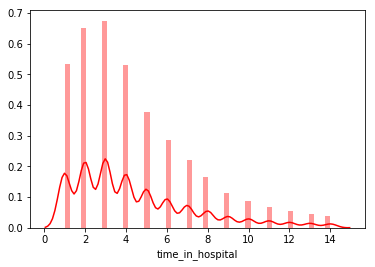

In [427]:
sns.distplot(numeric_data['time_in_hospital'], color="red")

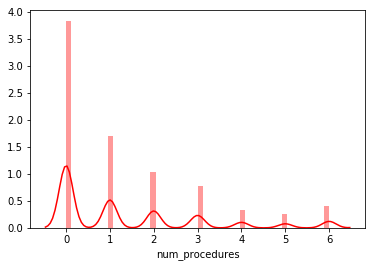

In [428]:
sns.distplot(numeric_data['num_procedures'], color="red")

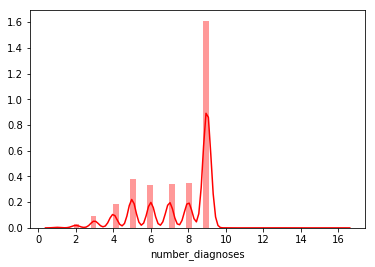

In [429]:
sns.distplot(numeric_data['number_diagnoses'], color="red")

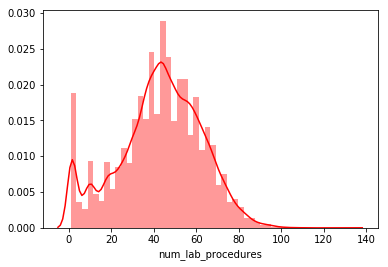

In [430]:
sns.distplot(numeric_data['num_lab_procedures'], color="red")

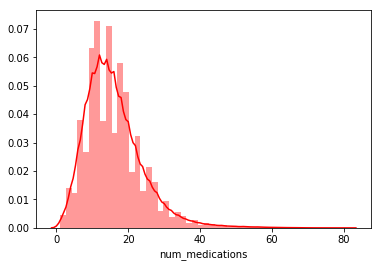

In [431]:
sns.distplot(numeric_data['num_medications'], color="red")

In [432]:
dia1['num_medications_log'] = np.log(dia1['num_medications'])

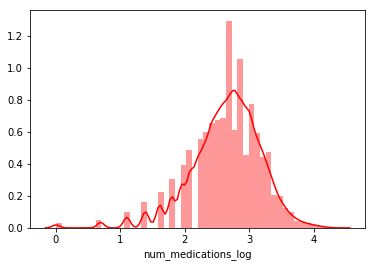

In [433]:
sns.distplot(dia1['num_medications_log'], color="red")

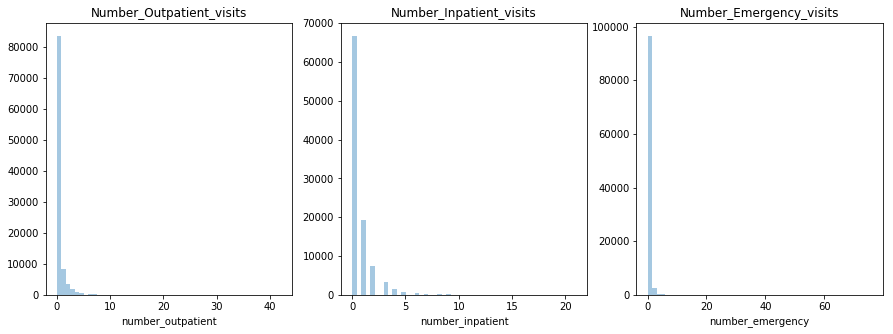

In [434]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=3)

# The amount of space above titles
y_title_margin = 1

ax[0].set_title("Number_Outpatient_visits",  y=y_title_margin)
ax[1].set_title("Number_Inpatient_visits",   y=y_title_margin)
ax[2].set_title("Number_Emergency_visits",   y=y_title_margin)

sns.distplot(dia1["number_outpatient"], kde=False, ax=ax[0])
sns.distplot(dia1["number_inpatient"],  kde=False, ax=ax[1])
sns.distplot(dia1["number_emergency"],  kde=False, ax=ax[2])

#### Log Transformation

In [435]:
dia1['number_outpatient_log1p'] = np.log1p(dia1['number_outpatient'])
dia1['number_emergency_log1p'] = np.log1p(dia1['number_emergency'])
dia1['number_inpatient_log1p'] = np.log1p(dia1['number_inpatient'])

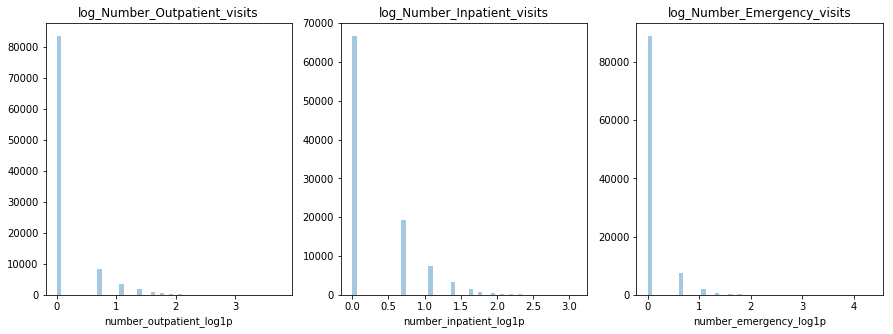

In [436]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=3)

# The amount of space above titles
y_title_margin = 1

ax[0].set_title("log_Number_Outpatient_visits",  y=y_title_margin)
ax[1].set_title("log_Number_Inpatient_visits",   y=y_title_margin)
ax[2].set_title("log_Number_Emergency_visits",   y=y_title_margin)

sns.distplot(dia1["number_outpatient_log1p"], kde=False, ax=ax[0])
sns.distplot(dia1["number_inpatient_log1p"],  kde=False, ax=ax[1])
sns.distplot(dia1["number_emergency_log1p"],  kde=False, ax=ax[2])

In [437]:
# The columns these columns are not very information to predict diabetes readmission at this point.
dia1.drop(['level_0', 'index', 'encounter_id', 'patient_nbr', 'admission_type_id',
           'discharge_disposition_id', 'admission_source_id', 'num_medications',
           'number_outpatient', 'number_emergency', 'number_inpatient'], inplace=True, axis=1)

## Explore the Target Variable

**There are three classes in the target variable.**

**Class 1: NO** - patients not readmitted,

**Class 2: <30** - readmitted <30 days after discharge

**Class 3: >30** - readmitted >30 days after discharge

Since we are only interested in <30 class we will assign 1 to these observations and 0 to all other observations. 

In [438]:
dia1['readmitted'].value_counts()

NO     53208
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [439]:
dia1['readmitted'] = [1 if i == '<30' else 0 for i in dia1['readmitted']]

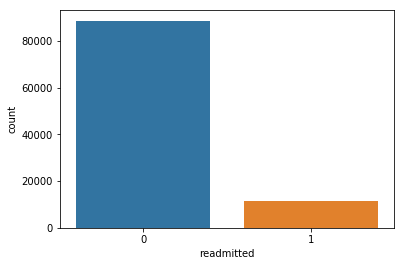

In [440]:
# Plot the target variable to quantify the distribution of the observation in the 2 classes
sns.countplot(x='readmitted', data=dia1)

In [441]:
dia_df = pd.get_dummies(dia1, drop_first=True)

In [442]:
dia_final = pd.concat([dia_df, diag_dummies_df], axis=1)

In [443]:
dia_final.shape

(100110, 988)

In [444]:
# Let's save the file for later use
dia_final.to_csv('dia_final.csv', index=False)

# Machine Learning

## Load libraries required for machine learning

In [445]:
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc
import pickle

import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler

So far we cleaned the data. It is now time to build some modles. 

The first thing to do is to shuffle the observations. 

In [446]:
df2 = pd.read_csv('dia_final.csv')

In [447]:
df2 = shuffle(df2)

In [448]:
# Define X, y
y = df2['readmitted']
print(y.shape)
X = df2.drop('readmitted', axis=1)
print(X.shape)

(100110,)
(100110, 987)


## Dealing with imbalanced data

In [449]:
def class_prevalence(label):
    return (sum(label)/len(label))

In [450]:
print(class_prevalence(y))

0.11344521026870442


The data is highly imbalanced. Only 11% of the observations belong to the class we are interested in. To overcome this I oversampled the data using Synthetic Minority Over-sampling Technique (SMOTE). 


In [451]:
# Instantiate SMOTE and fit
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
columns = X_train.columns

data_X_smote, data_y_smote = os.fit_sample(X_train, y_train)
data_X_smote = pd.DataFrame(data=data_X_smote, columns=columns)
data_y_smote = pd.DataFrame(data=data_y_smote, columns=['readmitted'])

# Check the numbers of our data
print("Length of oversampled data is ", len(data_X_smote))
print("Number of no subscription in oversampled data",
      len(data_y_smote[data_y_smote['readmitted'] == 0]))
print("Number of subscription", len(
    data_y_smote[data_y_smote['readmitted'] == 1]))
print("Proportion of no subscription data in oversampled data is ", len(
    data_y_smote[data_y_smote['readmitted'] == 0])/len(data_y_smote))
print("Proportion of subscription data in oversampled data is ", len(
    data_y_smote[data_y_smote['readmitted'] == 1])/len(data_y_smote))

Length of oversampled data is  124244
Number of no subscription in oversampled data 62122
Number of subscription 62122
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


**Train/Valid/Test**

Now it is time to split the data. The idea behind splitting the data is tomeasure how well the models would do on unseen data.


In [314]:
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.3, random_state=0)

## Linear Classifiers

### Logistic Regression

In [329]:
# logistic Regression
thresh = 0.5
lr_b = LogisticRegression()
lr_b.fit(data_X_smote, data_y_smote.values.ravel())

filename = 'finalized_lr_b_model.sav'
pickle.dump(lr_b, open(filename, 'wb'))

lr_b = pickle.load(open(filename, 'rb'))
lr_b_y_valid_preds = lr_b.predict(X_valid)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [330]:
# Make a confusion matrix and print
confusion_matrix = confusion_matrix(y_valid, lr_b_y_valid_preds)
print(confusion_matrix)

[[13332  5286]
 [ 1047  1358]]


In [331]:
# Make a classification report and print
lr_b_report = classification_report(y_valid, lr_b_y_valid_preds)
print(lr_b_report)

              precision    recall  f1-score   support

           0       0.93      0.72      0.81     18618
           1       0.20      0.56      0.30      2405

   micro avg       0.70      0.70      0.70     21023
   macro avg       0.57      0.64      0.55     21023
weighted avg       0.84      0.70      0.75     21023



In [332]:
print("Accuracy is {0:.2f}".format(
    accuracy_score(y_valid, lr_b_y_valid_preds)))
print("Precision is {0:.2f}".format(
    precision_score(y_valid, lr_b_y_valid_preds)))
print("Recall is {0:.2f}".format(recall_score(y_valid, lr_b_y_valid_preds)))
print("AUC is {0:.2f}".format(roc_auc_score(y_valid, lr_b_y_valid_preds)))

Accuracy is 0.70
Precision is 0.20
Recall is 0.56
AUC is 0.64


In [333]:
lr_coef = lr_b.coef_.ravel()
LR_Coef_table = pd.DataFrame({'Columns': data_X_smote.columns.tolist(),
                              'Coefficients': lr_coef}).sort_values(by='Coefficients', ascending=False)
LR_Coef_table

LR_Coef_table_b = LR_Coef_table.set_index('Columns')
LR_Coef_table_b

top20_positive_coefficients = LR_Coef_table_b.iloc[:25, :]
print(top20_positive_coefficients)

         Coefficients
Columns              
364          2.431824
755          2.308392
744          2.230753
391          2.229017
365.44       2.211285
313          2.007075
904          1.916936
23           1.885453
E817         1.880104
96           1.863557
913          1.842642
49           1.783240
136          1.781745
474          1.746721
48           1.718104
580          1.702191
894          1.645928
E814         1.630983
989          1.623256
742          1.613419
343          1.566100
250.31       1.550325
934          1.549940
964          1.537248
890          1.493655


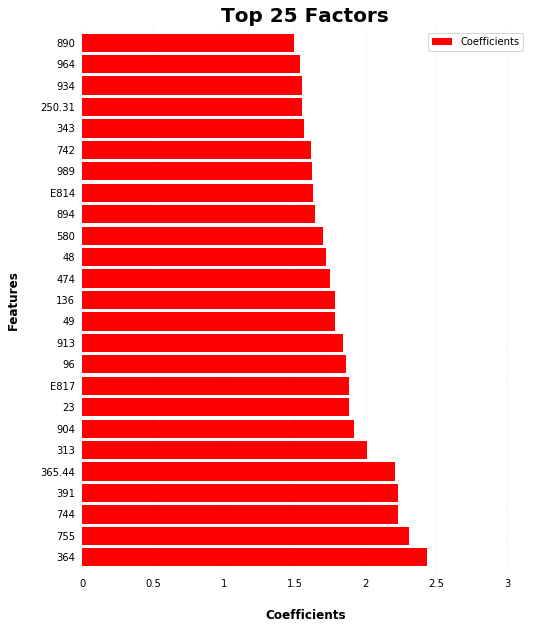

In [334]:
ax = top20_positive_coefficients.plot(
    kind='barh', figsize=(8, 10), color='r', zorder=2, width=0.85)
# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off",
               labelbottom="on", left="off", right="off", labelleft="on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed',
               alpha=0.4, color='#eeeeee', zorder=1)

    # Set x-axis label
    ax.set_xlabel("Coefficients",
                  labelpad=20, weight='bold', size=12)

    # Set y-axis label
    ax.set_ylabel("Features", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    ax.set_title("Top 25 Factors", weight='bold', size=20)

### Support Vector Classifier

Linear Kernel SVM algorithm is very sensitive to feature scaling, hence I normalized the features using sklearn preprocessor StandardScaler. 

**Scaling Features**

In [335]:
scaler = StandardScaler()
scaler.fit(data_X_smote)

scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

X_train_scaled = scaler.transform(data_X_smote)
X_valid_scaled = scaler.transform(X_valid)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


A critical parameter is, C (inverse of regularization strength), so it controls the bias/variance tradeoff. In particular it dictates how sensitive the decision boundary is to outliers.

**Choosing C with GridSearch**

In [ ]:
# Create my estimator and prepare the parameter grid dictionary
params_dict = {"C": np.logspace(-1, 3, 25)}
linear_svc_scaled_gs = LinearSVC()

# Fit the grid search
search = GridSearchCV(estimator=linear_svc_scaled_gs, param_grid=params_dict)

search.fit(X_train_scaled, data_y_smote.values.ravel())

print("Best parameter values:", search.best_params_)
print("CV Score with best parameter values:", search.best_score_)

In [ ]:
Best parameter values: {'C': 0.1}
CV Score with best parameter values: 0.6391351561613641

In [337]:
best_svm = LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
                     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                     verbose=0)

# Capture and fit the best estimator from across the grid search

best_svm.fit(X_train_scaled, data_y_smote.values.ravel())

linearsvc_tuned = 'linear_svc_tuned_scaled.sav'
pickle.dump(best_svm, open(linearsvc_tuned, 'wb'))

linearsvc_tuned = pickle.load(open(linearsvc_tuned, 'rb'))

linearsvc_tuned_preds = linearsvc_tuned.predict(X_valid_scaled)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [339]:
from sklearn.metrics import confusion_matrix
# Make a confusion matrix and print
linearsvc_cfm = confusion_matrix(
    y_valid, linearsvc_tuned.predict(X_valid_scaled))
linearsvc_cfm

array([[13127,  5491],
       [ 1076,  1329]])

In [340]:
# Make a classification report and print
lsvc_report = classification_report(
    y_valid, linearsvc_tuned.predict(X_valid_scaled))
print(lsvc_report)

              precision    recall  f1-score   support

           0       0.92      0.71      0.80     18618
           1       0.19      0.55      0.29      2405

   micro avg       0.69      0.69      0.69     21023
   macro avg       0.56      0.63      0.54     21023
weighted avg       0.84      0.69      0.74     21023



In [341]:
print("Accuracy is {0:.2f}".format(accuracy_score(
    y_valid, linearsvc_tuned.predict(X_valid_scaled))))
print("Precision is {0:.2f}".format(precision_score(
    y_valid, linearsvc_tuned.predict(X_valid_scaled))))
print("Recall is {0:.2f}".format(recall_score(
    y_valid, linearsvc_tuned.predict(X_valid_scaled))))
print("AUC is {0:.2f}".format(roc_auc_score(
    y_valid, linearsvc_tuned.predict(X_valid_scaled))))

Accuracy is 0.69
Precision is 0.19
Recall is 0.55
AUC is 0.63


In [359]:
coef = best_svm.coef_.ravel()

SVC_Coef_table = pd.DataFrame({'Columns': data_X_smote.columns.tolist(),
                               'Coefficients': coef}).sort_values(by='Coefficients', ascending=False)

SVC_Coef_table_b = SVC_Coef_table.set_index('Columns')
SVC_Coef_table_b

top25_positive_coefficients = SVC_Coef_table_b.iloc[:25, :]
print(top25_positive_coefficients)

                            Coefficients
Columns                                 
number_encounters               0.362906
744                             0.320398
age_[70-80)                     0.304113
age_[80-90)                     0.268511
age_[60-70)                     0.257770
age_[50-60)                     0.192066
894                             0.161962
age_[40-50)                     0.155636
365.44                          0.147461
391                             0.143552
E814                            0.129177
rosiglitazone_No                0.118687
age_[90-100)                    0.111022
975                             0.109109
age_[30-40)                     0.095999
rosiglitazone_Steady            0.090271
364                             0.082914
nateglinide_No                  0.079943
nateglinide_Steady              0.072789
age_[20-30)                     0.066807
glyburide-metformin_No          0.065097
glyburide_No                    0.058642
E922            

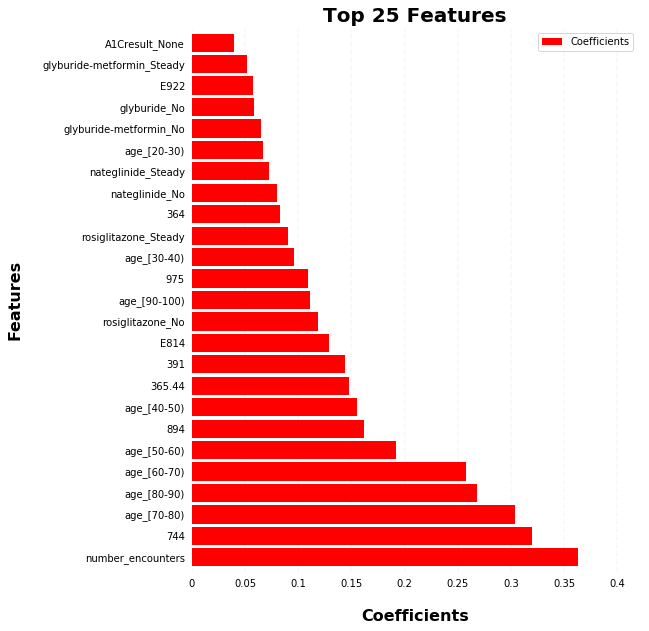

In [361]:
ax = top25_positive_coefficients.plot(
    kind='barh', figsize=(8, 10), color='r', zorder=2, width=0.85)
# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off",
               labelbottom="on", left="off", right="off", labelleft="on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed',
               alpha=0.4, color='#eeeeee', zorder=1)

    # Set x-axis label
    ax.set_xlabel("Coefficients",
                  labelpad=20, weight='bold', size=16)

    # Set y-axis label
    ax.set_ylabel("Features", labelpad=20, weight='bold', size=16)

    # Format y-axis label
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    ax.set_title("Top 25 Features", weight='bold', size=20)

## Tree-based Models

In [344]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Decision Trees

In [345]:
dt_b = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_b.fit(data_X_smote, data_y_smote.values.ravel())

filename_dt_b = 'finalized_dt_b_model.sav'
pickle.dump(dt_b, open(filename_dt_b, 'wb'))

dt_b = pickle.load(open(filename_dt_b, 'rb'))

#lr_y_train_preds = loaded_model.predict(data_X_smote)
dt_b_y_valid_preds = dt_b.predict(X_valid)

In [346]:
dt_3_cfm = confusion_matrix(y_valid, dt_b_y_valid_preds)
print(dt_3_cfm)

[[16260  2358]
 [ 1573   832]]


In [347]:
dt_b_report = classification_report(y_valid, dt_b_y_valid_preds)
print(dt_b_report)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89     18618
           1       0.26      0.35      0.30      2405

   micro avg       0.81      0.81      0.81     21023
   macro avg       0.59      0.61      0.59     21023
weighted avg       0.84      0.81      0.82     21023



In [348]:
print("Accuracy is {0:.2f}".format(
    accuracy_score(y_valid, dt_b_y_valid_preds)))
print("Precision is {0:.2f}".format(
    precision_score(y_valid, dt_b_y_valid_preds)))
print("Recall is {0:.2f}".format(recall_score(y_valid, dt_b_y_valid_preds)))
print("AUC is {0:.2f}".format(roc_auc_score(y_valid, dt_b_y_valid_preds)))

Accuracy is 0.81
Precision is 0.26
Recall is 0.35
AUC is 0.61


In [368]:
# Important Features
DT_Important_Features = {}
DT_Important_Features['Features'] = data_X_smote.columns.tolist()
DT_Important_Features['Importance'] = dt_b.feature_importances_.tolist()
DT_df = pd.DataFrame(DT_Important_Features).set_index(
    'Features').sort_values(by='Importance', ascending=False)
top_25_features = DT_df[:25]

In [369]:
top_25_features

,Importance
Features,
number_encounters,0.610933
number_inpatient_log1p,0.234129
age_[70-80),0.038742
gender_Male,0.026491
age_[50-60),0.017437
age_[80-90),0.016282
434,0.011640
age_[60-70),0.009854
A1Cresult_None,0.005277


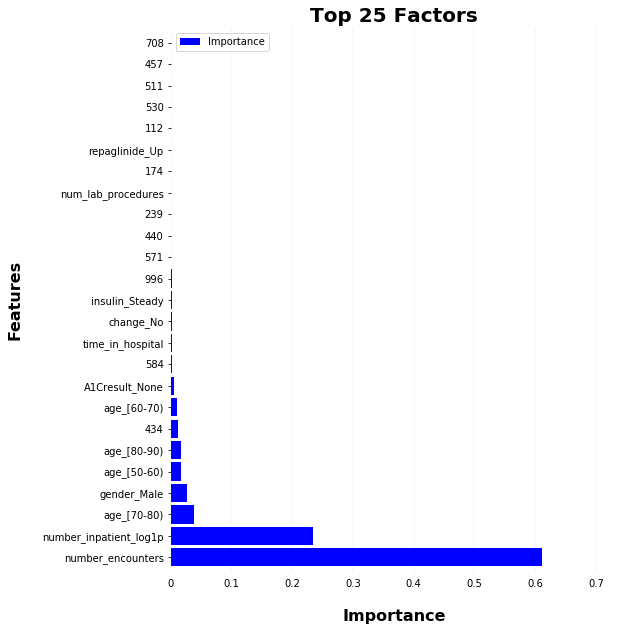

In [371]:
ax = top_25_features.plot(kind='barh', figsize=(
    8, 10), color='b', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis='both', which='both', bottom='off', top='off',
               labelbottom='on', right='off', labelleft='on')

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed',
               alpha=0.4, color='#eeeeee', zorder=1)

    # Set x-axis label
    ax.set_xlabel("Importance",
                  labelpad=20, weight='bold', size=16)

    # Set y-axis label
    ax.set_ylabel("Features", labelpad=20, weight='bold', size=16)

    # Format y-axis label
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    ax.set_title("Top 25 Factors", weight='bold', size=20)

### Random Forest

In [372]:
# Instantiate a random forest classifier with default parameters
rf3 = RandomForestClassifier()
rf3

# model fitting
rf3.fit(data_X_smote, data_y_smote)

# Pickle the model for later use
filename_rf3 = 'finalized_rf3_model.sav'
pickle.dump(rf3, open(filename_rf3, 'wb'))

# Load the model
rf3_model = pickle.load(open('finalized_rf3_model.sav', 'rb'))

#rf2_y_train_preds = rf2_model.predict(data_X_smote)
rf3_y_valid_preds = rf3_model.predict(X_valid)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


**Results**

In [373]:
cfm = confusion_matrix(y_valid, rf3_y_valid_preds)
cfm

array([[18493,   125],
       [ 2326,    79]])

In [374]:
print(classification_report(y_valid, rf3_y_valid_preds))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     18618
           1       0.39      0.03      0.06      2405

   micro avg       0.88      0.88      0.88     21023
   macro avg       0.64      0.51      0.50     21023
weighted avg       0.83      0.88      0.84     21023



In [375]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_valid, rf3_y_valid_preds)))
print("Precision is {0:.2f}".format(
    precision_score(y_valid, rf3_y_valid_preds)))
print("Recall is {0:.2f}".format(recall_score(y_valid, rf3_y_valid_preds)))
print("AUC is {0:.2f}".format(roc_auc_score(y_valid, rf3_y_valid_preds)))

Accuracy is 0.88
Precision is 0.39
Recall is 0.03
AUC is 0.51


### Random Forest - Hyperparameters RandomizedSearch

In [ ]:
# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [ ]:
rf4_RS = RandomizedSearchCV(estimator=rf3, param_distributions=random_grid,
                            n_iter=3, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [ ]:
rf4_RS.fit(data_X_smote, data_y_smote.values.ravel())

In [ ]:
best_random_grid = rf4_RS.best_params_
best_random_grid

**RandomForest - best hyperparameters**

In [378]:
clf_final = RandomForestClassifier(bootstrap=False,
                                   max_depth=10,
                                   min_samples_leaf=1,
                                   min_samples_split=40,
                                   n_estimators=1000)

clf_final.fit(data_X_smote, data_y_smote.values.ravel())

filename_rf_b = 'finalized_rf_rs_b_model.sav'
pickle.dump(clf_final, open(filename_rf_b, 'wb'))

clf_final_b = pickle.load(open(filename_rf_b, 'rb'))

clf_final_b_y_valid_preds = clf_final_b.predict(X_valid)

**Results**

In [379]:
clf_rf_rs_cfm = confusion_matrix(y_valid, clf_final_b_y_valid_preds)
print(clf_rf_rs_cfm)

[[16513  2105]
 [ 1820   585]]


In [380]:
clf_rf_rs_report = classification_report(y_valid, clf_final_b_y_valid_preds)
print(clf_rf_rs_report)

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     18618
           1       0.22      0.24      0.23      2405

   micro avg       0.81      0.81      0.81     21023
   macro avg       0.56      0.57      0.56     21023
weighted avg       0.82      0.81      0.82     21023



In [381]:
print("Accuracy is {0:.2f}".format(
    accuracy_score(y_valid, clf_final_b_y_valid_preds)))
print("Precision is {0:.2f}".format(
    precision_score(y_valid, clf_final_b_y_valid_preds)))
print("Recall is {0:.2f}".format(
    recall_score(y_valid, clf_final_b_y_valid_preds)))
print("AUC is {0:.2f}".format(roc_auc_score(
    y_valid, clf_final_b_y_valid_preds)))

Accuracy is 0.81
Precision is 0.22
Recall is 0.24
AUC is 0.57


### Gradient Boosting Machines

In [382]:
gbc4 = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
                                  max_depth=3, random_state=42)
gbc4.fit(data_X_smote, data_y_smote.values.ravel())

filename_gbc4 = 'finalized_gbc4_model.sav'
pickle.dump(gbc4, open(filename_gbc4, 'wb'))

gbc4_model = pickle.load(open(filename_gbc4, 'rb'))
gbc4_y_valid_predict = gbc4_model.predict(X_valid)

In [383]:
confusion_matrix = confusion_matrix(y_valid, gbc4_y_valid_predict)
print(confusion_matrix)

[[18439   179]
 [ 2319    86]]


In [384]:
print(classification_report(y_valid, gbc4_y_valid_predict))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     18618
           1       0.32      0.04      0.06      2405

   micro avg       0.88      0.88      0.88     21023
   macro avg       0.61      0.51      0.50     21023
weighted avg       0.82      0.88      0.84     21023



In [385]:
print("Accuracy is {0:.2f}".format(
    accuracy_score(y_valid, gbc4_y_valid_predict)))
print("Precision is {0:.2f}".format(
    precision_score(y_valid, gbc4_y_valid_predict)))
print("Recall is {0:.2f}".format(recall_score(y_valid, gbc4_y_valid_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(y_valid, gbc4_y_valid_predict)))

Accuracy is 0.88
Precision is 0.32
Recall is 0.04
AUC is 0.51


**GBM Hyperparameter tuning**

I will use AUC (Area Under Curve) as the evaluation metric and tune the model. AUC is a good way for evaluation for binary classification problem.

**Tuning max_depth**

In [397]:
gbc4_b = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
                                    random_state=42)

max_depths = np.linspace(1, 30, 8, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
    gbc4_b.fit(data_X_smote, data_y_smote.values.ravel())
    train_predict = gbc4_b.predict(data_X_smote)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        data_y_smote.values.ravel(), train_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_predict = gbc4_b.predict(X_valid)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        y_valid, y_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)


line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

**Tuning min_samples_leaf**

In [398]:
# Define the range of values
min_samples_leaf = [0.12, 0.14, 0.16, 0.18]

# Instantiate the model
gbc4_c = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=3,
                                    random_state=42)

train_results = []
test_results = []

for min_sample_leaf in min_samples_leaf:
    gbc4_c.fit(data_X_smote, data_y_smote.values.ravel())
    train_predict = gbc4_c.predict(data_X_smote)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        data_y_smote.values.ravel(), train_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_predict = gbc4_c.predict(X_valid)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        y_valid, y_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

# Plot the AUC vs the min_samples_leaf values
line1, = plt.plot(min_samples_leaf, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leaf, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

**Tuning min_samples_splits**

In [400]:
# Define the range of values
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

gbc4_d = GradientBoostingClassifier(n_estimators=50,
                                    learning_rate=1.0,
                                    max_depth=3,
                                    min_samples_leaf=0.12,
                                    random_state=42)

train_results_d = []
test_results_d = []
for min_samples_split in min_samples_splits:
    gbc4_d.fit(data_X_smote, data_y_smote.values.ravel())
    train_predict = gbc4_d.predict(data_X_smote)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        data_y_smote.values.ravel(), train_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results_d.append(roc_auc)

    y_predict = gbc4_d.predict(X_valid)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        y_valid, y_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results_d.append(roc_auc)


line1, = plt.plot(min_samples_splits, train_results_d, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results_d, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min_samples_splits')
plt.show()

**Tuning Learning Rates**

In [401]:
# Define the range of values
learning_rates = [0.001, 0.01, 0.1, 0.2, 0, 3]

gbc4_e = GradientBoostingClassifier(n_estimators=50,
                                    learning_rate=1.0,
                                    max_depth=3,
                                    min_samples_leaf=0.12,
                                    min_samples_split=0.2,
                                    random_state=42)

train_results_e = []
test_results_e = []
for learning_rate in learning_rates:
    gbc4_e.fit(data_X_smote, data_y_smote.values.ravel())
    train_predict = gbc4_e.predict(data_X_smote)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        data_y_smote.values.ravel(), train_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results_e.append(roc_auc)

    y_predict = gbc4_e.predict(X_valid)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        y_valid, y_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results_e.append(roc_auc)

# Plot AUC vs Learning Rates
line1, = plt.plot(learning_rates, train_results_e, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results_e, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min_samples_splits')
plt.show()

In [387]:
gbc4_final = GradientBoostingClassifier(n_estimators=200,
                                        max_depth=3,
                                        min_samples_leaf=0.12,
                                        min_samples_split=0.2,
                                        learning_rate=0.1,
                                        random_state=42)

In [388]:
gbc4_final.fit(data_X_smote, data_y_smote.values.ravel())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.12, min_samples_split=0.2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [389]:
gbc4_final_y_valid_predict = gbc4_final.predict(X_valid)

In [391]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_valid, gbc4_final_y_valid_predict)
print(confusion_matrix)

[[18346   272]
 [ 2294   111]]


In [392]:
print(classification_report(y_valid, gbc4_final_y_valid_predict))

              precision    recall  f1-score   support

           0       0.89      0.99      0.93     18618
           1       0.29      0.05      0.08      2405

   micro avg       0.88      0.88      0.88     21023
   macro avg       0.59      0.52      0.51     21023
weighted avg       0.82      0.88      0.84     21023



In [393]:
print("Accuracy is {0:.2f}".format(
    accuracy_score(y_valid, gbc4_final_y_valid_predict)))
print("Precision is {0:.2f}".format(
    precision_score(y_valid, gbc4_final_y_valid_predict)))
print("Recall is {0:.2f}".format(
    recall_score(y_valid, gbc4_final_y_valid_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(
    y_valid, gbc4_final_y_valid_predict)))

Accuracy is 0.88
Precision is 0.29
Recall is 0.05
AUC is 0.52


## Model Evaluation

Let's summarize the AUC results from all our models

In [404]:
df_results = pd.DataFrame({
    'classifier': ['Logistic Regression', 'Support Vector Classifier', 'Decision Tree', 'Random Forest - Tuned', 'Gradient Boosting Machines - Tuned'],
    'auc': [0.64, 0.63, 0.61, 0.57, 0.52]})

In [405]:
df_results

,auc,classifier
0,0.64,Logistic Regression
1,0.63,Support Vector Classifier
2,0.61,Decision Tree
3,0.57,Random Forest - Tuned
4,0.52,Gradient Boosting Machines - Tuned


# Conclusion

Through this project, I created a binary classifier to predict the probability that a patient with diabetes would be readmitted to the hospital within 30 days. On held out data, my best model was Logistic Regression with AUC of 0.64. My best model performs approximately 1.8 times better than randomly selecting patients.

Linear Classifiers performed better than the tree-based models.

Linear classifiers and Tree-based classifiers identified a number of diagnostic codes as top predictors for patient readmission. 

* Patients with a history of readmission are more likley to be readmitted again. 

* Age of the patients is another key feature. Older patients are more likely to be readmitted. Hence more attention should be paid to older patients. 

* Diabetes Medicines 'Rosiglitazone', 'Nateglinide', 'Glyburide', Glyburide-metformin'  seem to control patients from readmission. Patients not given these drugs are more likely to be readmitted.


In [1]:
!jupyter nbconvert --to html Case_Study_Diabetes_UCI.ipynb

[NbConvertApp] Converting notebook Case_Study_Diabetes_UCI.ipynb to html
[NbConvertApp] Writing 703307 bytes to Case_Study_Diabetes_UCI.html
